# Predicting Success: Machine Learning Unlocks Insights from Pakistan’s Largest E-commerce Dataset


The rapid growth of e-commerce in Pakistan has generated massive volumes of transactional data, offering unprecedented opportunities for data-driven decision-making.  
The dataset used in this project — one of the largest publicly available e-commerce datasets from the country — encompasses millions of transactions including detailed information about customer behaviors, order statuses, payment types, and product categories.

In the first phase of our project, we conducted an in-depth Exploratory Data Analysis (EDA) to understand the dataset’s structure, uncover hidden trends, address missing values, and detect anomalies.  
Our EDA efforts revealed important behavioral patterns, seasonality effects, and operational bottlenecks, laying a strong foundation for predictive modeling.

Building upon these findings, the second phase — detailed in this report — aims to answer three key research questions through the application of machine learning models:

- **Can we predict whether an order will be completed or cancelled based on historical data?**
- **Can we group our customer base into meaningful clusters, and what insights does that reveal?**
- **Can we predict future sales based on historical patterns?**

Each of these questions targets practical, high-impact areas of e-commerce operations, demonstrating the power of predictive analytics to shift from retrospective analysis to proactive strategy formulation.

## Imports ##

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)
import os
import warnings
import time
from IPython.display import display, HTML
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
import tensorflow as tf

## RQ1: Can we predict whether an order will be completed or cancelled based on historical data? ##

To predict whether an order will complete or cancel, we built **two** models in parallel:

1. **Random Forest** with time‑aware cross‑validation  
2. **Neural Network** (MLP) with BatchNorm & LeakyReLU


<h1> 1. RANDOM FOREST IMPLEMENTATION <h1>

**Workflow**  
- **Features**: price, quantity, discount, grand_total plus cyclical time flags (sine/cosine of quarter, month, day‑of‑week), one‑hot `category` & `payment_method`  
- **Split**: `TimeSeriesSplit(n_splits=5)` to avoid “looking into the future”  
- **Model**: `RandomForestClassifier(n_estimators=200, class_weight='balanced')`

```python
# Time‑aware cross‑validation loop
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X, y):
    model = RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_proba = model.predict_proba(X.iloc[test_idx])[:, 1]
    auc_scores.append(roc_auc_score(y.iloc[test_idx], y_proba))
```  

 20%|██        | 1/5 [00:09<00:36,  9.24s/it]


Fold 1 AUC: 0.7656


 40%|████      | 2/5 [00:26<00:41, 13.91s/it]


Fold 2 AUC: 0.7009


 60%|██████    | 3/5 [00:52<00:39, 19.62s/it]


Fold 3 AUC: 0.6544


 80%|████████  | 4/5 [01:27<00:25, 25.62s/it]


Fold 4 AUC: 0.6740


100%|██████████| 5/5 [02:13<00:00, 26.66s/it]


Fold 5 AUC: 0.7033

Overall Cross-Validated Results
Confusion Matrix:


[[162711  63843]
 [103959 152257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66    226554
           1       0.70      0.59      0.64    256216

    accuracy                           0.65    482770
   macro avg       0.66      0.66      0.65    482770
weighted avg       0.66      0.65      0.65    482770

Mean AUC across folds: 0.6996


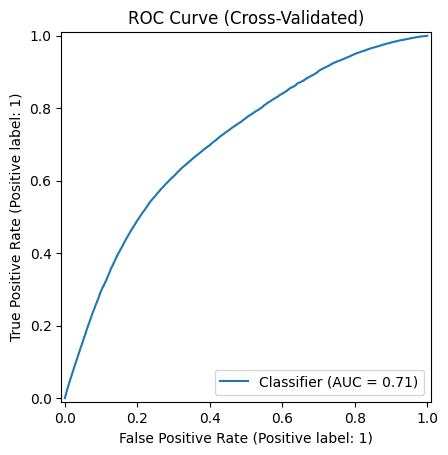

In [2]:
df = pd.read_csv('preprocessed_dataset.csv',
                 parse_dates=['created_at'], low_memory=False)

df = df[df['status'].isin(['complete', 'canceled'])].copy()
df['is_complete'] = (df['status'] == 'complete').astype(int)

df['quarter']     = df['created_at'].dt.quarter
df['month']       = df['created_at'].dt.month
df['day_of_week'] = df['created_at'].dt.dayofweek 

# cycle lengths
Q, M, D = 4, 12, 7

# sine / cosine transforms
df['q_sin'] = np.sin(2*np.pi*(df['quarter'] - 1) / Q)
df['q_cos'] = np.cos(2*np.pi*(df['quarter'] - 1) / Q)

df['m_sin'] = np.sin(2*np.pi*(df['month'] - 1) / M)
df['m_cos'] = np.cos(2*np.pi*(df['month'] - 1) / M)

df['d_sin'] = np.sin(2*np.pi* df['day_of_week']    / D)
df['d_cos'] = np.cos(2*np.pi* df['day_of_week']    / D)

df = df.sort_values('created_at')

cat_features = ['category', 'payment_method'] 
num_features = ['price', 'qty_ordered', 'discount_amount', 'grand_total', 'q_sin', 'q_cos',
           'm_sin', 'm_cos', 'd_sin', 'd_cos']

X_num = df[num_features]
X_cat = pd.get_dummies(df[cat_features], drop_first=True)
X = pd.concat([X_cat,X_num],axis=1)
y = df['is_complete']

# 3. train-test split
tscv = TimeSeriesSplit(n_splits=5)

all_y_true = []
all_y_pred = []
all_y_proba = []
auc_scores = []

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X, y),total=5),1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    all_y_proba.extend(y_proba)
    
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)
    
    print(f"\nFold {fold} AUC: {auc:.4f}")

# summarize results
print("\nOverall Cross-Validated Results")
print("Confusion Matrix:")
print(confusion_matrix(all_y_true, all_y_pred))
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred))
print(f"Mean AUC across folds: {np.mean(auc_scores):.4f}")

RocCurveDisplay.from_predictions(all_y_true, all_y_proba)
plt.title('ROC Curve (Cross-Validated)')
plt.show()

## Checking top 20 features which influenced order completion ##


Top 20 Feature Importances:
grand_total                        0.245915
price                              0.225465
discount_amount                    0.113300
payment_method_cash_on_delivery    0.099083
d_sin                              0.055445
payment_method_payment_gateway     0.036118
d_cos                              0.033780
payment_method_easypay             0.026135
m_cos                              0.023959
m_sin                              0.023078
qty_ordered                        0.014684
category_Mobiles & Tablets         0.009320
payment_method_credit              0.009212
q_sin                              0.007987
category_Men's Fashion             0.007049
category_Others                    0.006900
payment_method_jazzcash            0.006818
category_Women's Fashion           0.006772
q_cos                              0.006454
category_Gifts                     0.006303
dtype: float64


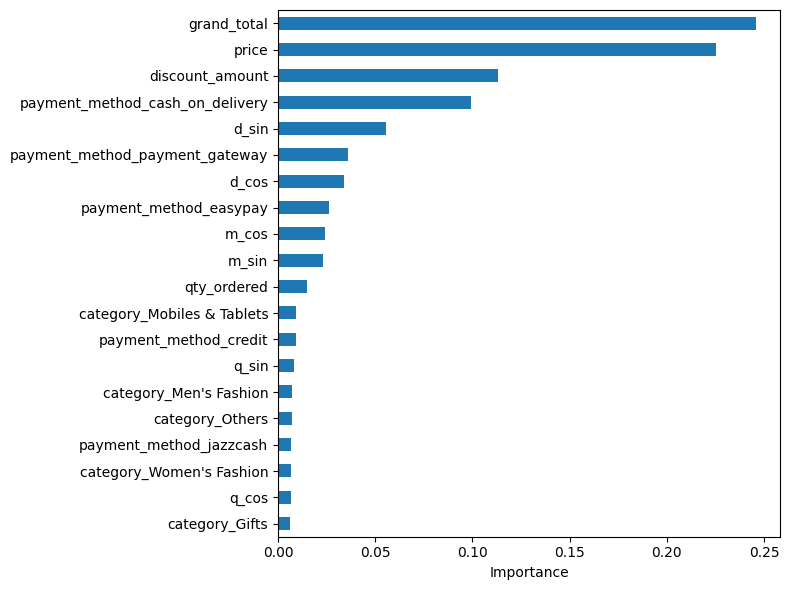

In [3]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top = importances.sort_values(ascending=False).head(20)

print("\nTop 20 Feature Importances:")
print(top)

plt.figure(figsize=(8, 6))
top.plot.barh()
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Analysis of top features which affected order completion ##

In [4]:
top4 = top.index[:4].tolist()
print("\nDirectional Analysis for Top 4 Features:")
for feature in top4:
    print(f"\n*{feature}*")
    if feature in ['grand_total', 'price', 'discount_amount']:
        stats = df.groupby('status')[feature].agg(['mean', 'median'])
        # formatted print
        for stat in ['mean', 'median']:
            vals = stats[stat].apply(lambda x: f"{x:,.2f}")
            print(f"  {stat.title()}:  Canceled = {vals['canceled']} | Complete = {vals['complete']}")
    elif feature == 'payment_method_cash_on_delivery':
        # compute cancellation/completion rates for COD
        rates = df[df['payment_method'] == 'cash_on_delivery']['status'].value_counts(normalize=True)
        can = rates.get('canceled', 0)
        comp = rates.get('complete', 0)
        print(f"  Cash on Delivery - Cancellation Rate: {can:.2%}, Completion Rate: {comp:.2%}")
    else:
        print("  (No directional analysis implemented for this feature.)")


Directional Analysis for Top 4 Features:

*grand_total*
  Mean:  Canceled = 10,027.07 | Complete = 3,973.33
  Median:  Canceled = 1,499.00 | Complete = 699.00

*price*
  Mean:  Canceled = 9,239.00 | Complete = 3,956.78
  Median:  Canceled = 1,299.00 | Complete = 699.00

*discount_amount*
  Mean:  Canceled = 503.90 | Complete = 426.07
  Median:  Canceled = 0.00 | Complete = 0.00

*payment_method_cash_on_delivery*
  Cash on Delivery - Cancellation Rate: 27.97%, Completion Rate: 72.03%


**Cross‑Validated Performance**  
- **Mean AUC:** 0.6996  
- **Accuracy:** 0.65  
- **Precision / Recall (Canceled=1):** 0.70 / 0.59

**Feature Importances (Top 4)**  
| Feature                         | Importance |  
|---------------------------------|-----------:|  
| grand_total                     | 0.246      |  
| price                           | 0.225      |  
| discount_amount                 | 0.113      |  
| payment_method_cash_on_delivery | 0.099      |

<h1> 2. NEURAL NETWORK IMPLEMENTATION <h1>

**Workflow**  
- **Architecture**: Sequential MLP with layers [128 → 64], each followed by `BatchNormalization()` and `LeakyReLU(α=0.1)`, then `Dropout(0.3)`  
- **Training**: 80/20 time‑based split, `Adam(1e‑3)`, early stopping on validation AUC

```python
# Build & train MLP with BatchNorm + LeakyReLU
model = Sequential([
    Dense(128, use_bias=False), BatchNormalization(), LeakyReLU(0.1), Dropout(0.3),
    Dense(64,  use_bias=False), BatchNormalization(), LeakyReLU(0.1), Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC()]
)
model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=256,
    callbacks=[EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)],
    verbose=2
)
```

GPUs available: []
Shapes — X_train: (463461, 29) X_test: (115866, 29)


c:\Users\Salaar Masood\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\Salaar Masood\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,737 (49.75 KB)

 Trainable params: 12,353 (48.25 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
1630/1630 - 5s - 3ms/step - accuracy: 0.6908 - auc: 0.7389 - loss: 0.5968 - val_accuracy: 0.6544 - val_auc: 0.7055 - val_loss: 0.6269
Epoch 2/100
1630/1630 - 5s - 3ms/step - accuracy: 0.7036 - auc: 0.7577 - loss: 0.5786 - val_accuracy: 0.6566 - val_auc: 0.7085 - val_loss: 0.6298
Epoch 3/100
1630/1630 - 5s - 3ms/step - accuracy: 0.7054 - auc: 0.7610 - loss: 0.5756 - val_accuracy: 0.6562 - val_auc: 0.7088 - val_loss: 0.6280
Epoch 4/100
1630/1630 - 4s - 3ms/step - accuracy: 0.7067 - auc: 0.7629 - loss: 0.5739 - val_accuracy: 0.6537 - val_auc: 0.7086 - val_loss: 0.6270
Epoch 5/100
1630/1630 - 3s - 2ms/step - accuracy: 0.7069 - auc: 0.7646 - loss: 0.5724 - val_accuracy: 0.6554 - val_auc: 0.7131 - val_loss: 0.6251
Epoch 6/100
1630/1630 - 3s - 2ms/step - accuracy: 0.7082 - auc: 0.7659 - loss: 0.5714 - val_accuracy: 0.6538 - val_auc: 0.7122 - val_loss: 0.6240
Epoch 7/100
1630/1630 - 5s - 3ms/step - accuracy: 0.7085 - auc: 0.7668 - loss: 0.5704 - val_accuracy: 0.6500 - val_auc: 0.70

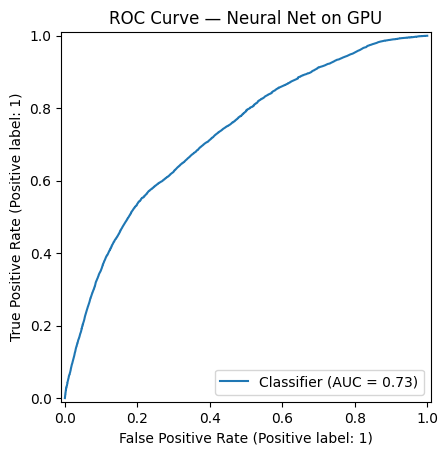

In [5]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# load the dataset
df = pd.read_csv(
    'preprocessed_dataset.csv',
    parse_dates=['created_at'],
    low_memory=False
)
df = df[df['status'].isin(['complete','canceled'])].copy()
df['is_complete'] = (df['status'] == 'complete').astype(int)

df['quarter']     = df['created_at'].dt.quarter
df['month']       = df['created_at'].dt.month
df['day_of_week'] = df['created_at'].dt.dayofweek

Q, M, D = 4, 12, 7
df['q_sin'] = np.sin(2 * np.pi * (df['quarter']-1) / Q)
df['q_cos'] = np.cos(2 * np.pi * (df['quarter']-1) / Q)
df['m_sin'] = np.sin(2 * np.pi * (df['month']-1) / M)
df['m_cos'] = np.cos(2 * np.pi * (df['month']-1) / M)
df['d_sin'] = np.sin(2 * np.pi * df['day_of_week'] / D)
df['d_cos'] = np.cos(2 * np.pi * df['day_of_week'] / D)

# train-test split
df = df.sort_values('created_at').reset_index(drop=True)
cutoff = int(len(df) * 0.8)
train_df = df.iloc[:cutoff]
test_df  = df.iloc[cutoff:]

# prepare features
cat_feats = ['category', 'payment_method']
num_feats = [
    'price','qty_ordered','discount_amount','grand_total',
    'q_sin','q_cos','m_sin','m_cos','d_sin','d_cos'
]

X_train_num = train_df[num_feats].values
X_test_num  = test_df[num_feats].values

# one-hot encode categoricals
X_train_cat = pd.get_dummies(train_df[cat_feats], drop_first=True)
X_test_cat  = pd.get_dummies(test_df[cat_feats],  drop_first=True)
X_train_cat, X_test_cat = X_train_cat.align(
    X_test_cat, join='left', axis=1, fill_value=0
)

# scaling numerics
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num  = scaler.transform(X_test_num)

# combining numeric + categorical
X_train = np.hstack([X_train_num, X_train_cat.values])
X_test  = np.hstack([X_test_num,  X_test_cat.values])
y_train = train_df['is_complete'].values
y_test  = test_df['is_complete'].values

print("Shapes — X_train:", X_train.shape, "X_test:", X_test.shape)

# building and compiling the model with BatchNorm + LeakyReLU
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, use_bias=False),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, use_bias=False),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
model.summary()

# training with EarlyStopping
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=256,
    callbacks=[es],
    verbose=2
)

# printing accuracy and AUC for each epoch
print("\nPer-epoch metrics:")
for i, (acc, val_acc, auc, val_auc) in enumerate(zip(
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['auc'],
        history.history['val_auc']
    ), start=1):
    print(f"Epoch {i:03d} — acc: {acc:.4f}, val_acc: {val_acc:.4f}, auc: {auc:.4f}, val_auc: {val_auc:.4f}")

# evaluate on test set
y_proba = model.predict(X_test).ravel()
y_pred  = (y_proba >= 0.5).astype(int)

test_acc = np.mean(y_pred == y_test)
test_auc = roc_auc_score(y_test, y_proba)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title('ROC Curve — Neural Net on GPU')
plt.show()

  

**Hold‑out Performance**  
- **Test AUC:** 0.7302  
- **Test Accuracy:** 0.6747  
- **Precision / Recall (Canceled=1):** 0.67 / 0.56

**Confusion Matrix**  
|             | Pred=Complete | Pred=Canceled |  
|-------------|--------------:|--------------:|  
| Actual=Complete | 48 275       | 14 414         |  
| Actual=Canceled | 23 273       | 29 904         |

## RQ2: Can we group our customer base into clusters? What does that reveal about our target audience? ###

## Constants and Parameters ##

- **DATASET_PATH**: File path to the preprocessed dataset.
- **CUSTOMER_ID_COL**: Column name for customer ID.
- **ORDER_ID_COL**: Column name for order ID.

- **AGGREGATION_METRICS**: How to summarize data per customer (total spending, frequency, quantity, discount).

- **FEATURES_FOR_CLUSTERING_BASE**: Features selected for clustering (spending, frequency, averages, discounts).

- **MAX_K_TO_TEST**: Max clusters to try for Elbow/Silhouette methods.
- **SILHOUETTE_SAMPLE_SIZE**: Limit sample size for silhouette scoring.
- **DEFAULT_K**: Default cluster count if auto-selection fails.

In [21]:
DATASET_PATH = 'preprocessed_dataset.csv'
CUSTOMER_ID_COL = 'customer_id'
ORDER_ID_COL = 'increment_id'

AGGREGATION_METRICS = {
    'total_spending': ('grand_total', 'sum'),
    'frequency': (ORDER_ID_COL, 'nunique'),
    'total_quantity': ('qty_ordered', 'sum'),
    'total_discount': ('discount_amount', 'sum'),
}

FEATURES_FOR_CLUSTERING_BASE = [
    'total_spending', 'frequency', 'average_order_value',
    'total_quantity', 'average_quantity_per_order',
    'total_discount', 'average_discount_per_order'
]

MAX_K_TO_TEST = 10
SILHOUETTE_SAMPLE_SIZE = 15000
DEFAULT_K = 3

# Load and Validate Dataset

- Check if the dataset file exists; exit if not found.
- Load the dataset into a DataFrame and print its original shape.
- Handle loading errors gracefully with a try-except block.
- Verify that the customer ID column exists; exit if missing.
- Drop rows with missing customer IDs and report how many were dropped.
- Count and display the number of unique customers remaining.

In [22]:

if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    exit()
else:
    print(f"Loading dataset from: {DATASET_PATH}")
    try:
        df = pd.read_csv(DATASET_PATH)
        print(f"Dataset loaded successfully. Original shape: {df.shape}")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        exit()


if CUSTOMER_ID_COL not in df.columns:
    print(f"Error: Customer ID column '{CUSTOMER_ID_COL}' not found.")
    exit()

original_rows = df.shape[0]
df.dropna(subset=[CUSTOMER_ID_COL], inplace=True)
rows_dropped = original_rows - df.shape[0]
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} rows with missing '{CUSTOMER_ID_COL}'.")

unique_customers = df[CUSTOMER_ID_COL].nunique()
print(f"Found {unique_customers} unique customers.")


Loading dataset from: preprocessed_dataset.csv


C:\Users\Salaar Masood\AppData\Local\Temp\ipykernel_23728\2595366713.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATASET_PATH)


Dataset loaded successfully. Original shape: (582292, 21)
Dropped 11 rows with missing 'customer_id'.
Found 115081 unique customers.


# Aggregate Customer Purchasing Data

- Check if all required columns exist; exit if any are missing.
- Group data by customer ID and aggregate spending, orders, quantity, and discounts.
- Create new derived features:
  - `average_order_value` = total spending / frequency
  - `average_quantity_per_order` = total quantity / frequency
  - `average_discount_per_order` = total discount / frequency
- Print the shape of the aggregated customer dataset.

In [23]:
print("\nAggregating purchasing data per customer...")
required_agg_cols = [CUSTOMER_ID_COL, ORDER_ID_COL] + [val[0] for val in AGGREGATION_METRICS.values()]
missing_req_cols = [col for col in required_agg_cols if col not in df.columns]
if missing_req_cols:
    print(f"Error: Missing required columns for aggregation: {list(set(missing_req_cols))}")
    exit()


customer_agg = df.groupby(CUSTOMER_ID_COL).agg(**AGGREGATION_METRICS).reset_index()


if 'frequency' in customer_agg.columns and 'total_spending' in customer_agg.columns:
    customer_agg['average_order_value'] = customer_agg.apply(
        lambda row: row['total_spending'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)
if 'frequency' in customer_agg.columns and 'total_quantity' in customer_agg.columns:
    customer_agg['average_quantity_per_order'] = customer_agg.apply(
        lambda row: row['total_quantity'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)
if 'frequency' in customer_agg.columns and 'total_discount' in customer_agg.columns:
    customer_agg['average_discount_per_order'] = customer_agg.apply(
        lambda row: row['total_discount'] / row['frequency'] if row['frequency'] > 0 else 0, axis=1)

print(f"Customer aggregated data shape: {customer_agg.shape}")



Aggregating purchasing data per customer...
Customer aggregated data shape: (115081, 8)


# Feature Selection, Cleaning, and Scaling

- Select features available for clustering; exit if none are found.
- Warn if only a subset of expected features is available.
- Handle missing values (fill NaNs with 0) and infinite values (replace with 0).
- Scale features to zero mean and unit variance using `StandardScaler`.
- Output the shape of the scaled feature set.

In [24]:

actual_features = [f for f in FEATURES_FOR_CLUSTERING_BASE if f in customer_agg.columns]
if not actual_features:
    print("Error: No clustering features exist in the aggregated data.")
    exit()
elif len(actual_features) < len(FEATURES_FOR_CLUSTERING_BASE):
    print(f"Warning: Using subset of features: {actual_features}")

X_clustering = customer_agg[actual_features].copy()


if X_clustering.isnull().sum().sum() > 0:
    print("Warning: Filling NaN values with 0 before scaling.")
    X_clustering = X_clustering.fillna(0)

infinite_mask = np.isinf(X_clustering).any()
if infinite_mask.any():
    print("Warning: Replacing infinite values with 0 before scaling.")
    X_clustering = X_clustering.replace([np.inf, -np.inf], 0)


print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
print(f"Scaled features shape: {X_scaled.shape}")




Scaling features using StandardScaler...
Scaled features shape: (115081, 7)


# Elbow Method: Determine Optimal Number of Clusters (k)

- Calculate WCSS (Within-Cluster Sum of Squares) for different values of k (from 1 to MAX_K_TO_TEST).
- WCSS measures how tightly the data points fit within a cluster — lower is better.
- For each k:
  - Fit a KMeans model.
  - Store the WCSS (inertia) value.
- Plot WCSS vs. number of clusters (k).

## How the Elbow Method Works (Simple Explanation):
- As k increases, WCSS decreases (clusters fit better).
- Initially, WCSS drops sharply, but after a point ("the elbow"), the rate of improvement slows down.
- The "elbow point" suggests a good trade-off: enough clusters to capture structure without overfitting.
- Choose k where the curve visibly bends (forms an elbow shape).

- Final note: Manual inspection of the plot is needed to spot the elbow.


Calculating WCSS for Elbow Method...
Elbow method calculation time: 6.07 seconds


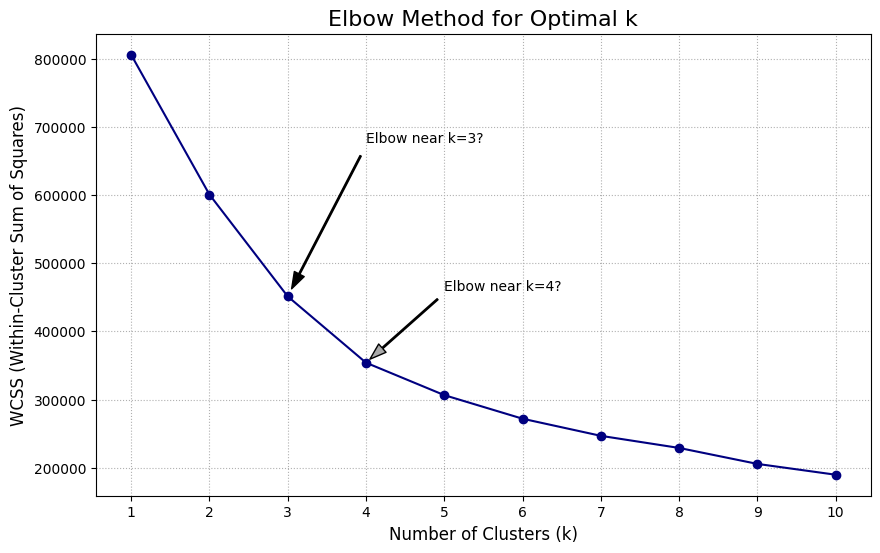

Interpret the plot: Look for point(s) where the rate of decrease slows down (the 'elbow').


In [25]:
print("\nCalculating WCSS for Elbow Method...")
wcss = []
possible_k_elbow = range(1, MAX_K_TO_TEST + 1)
start_elbow = time.time()

for k_val in possible_k_elbow:
    kmeans_test = KMeans(n_clusters=k_val, init='k-means++', random_state=42, n_init=10)
    kmeans_test.fit(X_scaled)
    wcss.append(kmeans_test.inertia_)

end_elbow = time.time()
print(f"Elbow method calculation time: {end_elbow - start_elbow:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(possible_k_elbow, wcss, marker='o', linestyle='-', color='navy')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(possible_k_elbow)
if len(wcss) > 2:
    plt.annotate('Elbow near k=3?', xy=(3, wcss[2]), xytext=(4, wcss[2]*1.5),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                 fontsize=10)
if len(wcss) > 3:
    plt.annotate('Elbow near k=4?', xy=(4, wcss[3]), xytext=(5, wcss[3]*1.3),
                 arrowprops=dict(facecolor='darkgrey', shrink=0.05, width=1, headwidth=8),
                 fontsize=10)

plt.grid(True, linestyle=':')
plt.show()
print("Interpret the plot: Look for point(s) where the rate of decrease slows down (the 'elbow').")



# Silhouette Score Method (Choosing Best k)

- For each value of k (from 2 to MAX_K_TO_TEST):
  - Run KMeans clustering.
  - Calculate the Silhouette Score (how well points fit in their cluster).
- Higher Silhouette Score = better clustering.

- Plot Silhouette Scores for different k values.
- Pick the k with the highest score.
- If no good score found, use the default k.

---

# What is Silhouette Score? 

- Measures how well a point belongs to its cluster.
- Score close to +1 = good cluster fit.
- Score near 0 = unclear cluster fit.
- Negative score = wrong cluster.

👉 Higher average scores mean better, clearer clusters!

---

# Key Idea

- **Best k** = the one with the **highest Silhouette Score**.
- Helps choose k without guessing.


Calculating Silhouette Scores...
Using sample of 15000 for Silhouette (total: 115081)
  k=2, Silhouette Score: N/A (only 1 cluster assigned).
  k=3, Silhouette Score: 0.9760
  k=4, Silhouette Score: 0.7949
  k=5, Silhouette Score: 0.7758
  k=6, Silhouette Score: 0.7685
  k=7, Silhouette Score: 0.7604
  k=8, Silhouette Score: 0.7068
  k=9, Silhouette Score: 0.7044
  k=10, Silhouette Score: 0.7051
Silhouette score calculation time: 28.18 seconds


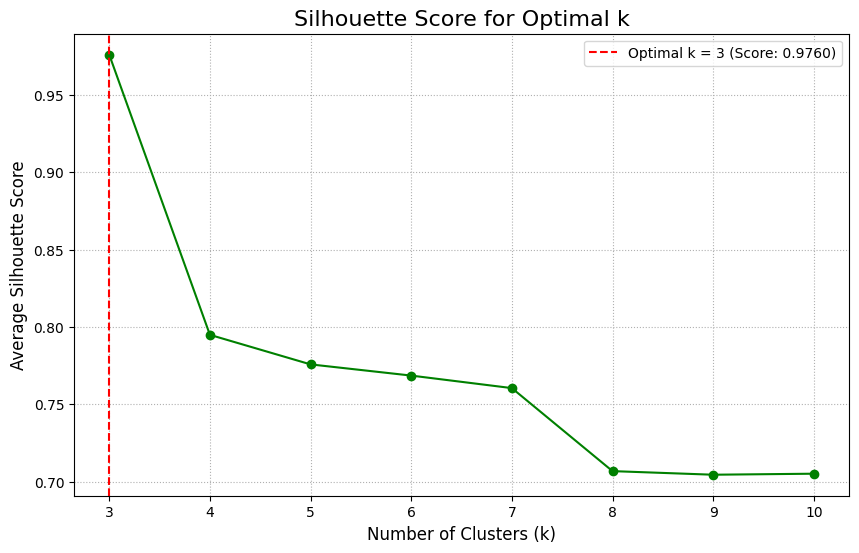


Optimal k suggested by Silhouette Score: 3

Selected k = 3 based on Silhouette score.


In [26]:
print("\nCalculating Silhouette Scores...")
silhouette_scores = []
possible_k_sil = range(2, MAX_K_TO_TEST + 1)
start_sil = time.time()
optimal_k_silhouette = -1


X_silhouette = X_scaled
indices_silhouette = None
if SILHOUETTE_SAMPLE_SIZE is not None and X_scaled.shape[0] > SILHOUETTE_SAMPLE_SIZE:
    print(f"Using sample of {SILHOUETTE_SAMPLE_SIZE} for Silhouette (total: {X_scaled.shape[0]})")
    indices_silhouette = np.random.choice(X_scaled.shape[0], SILHOUETTE_SAMPLE_SIZE, replace=False)
    X_silhouette = X_scaled[indices_silhouette]
else:
     print(f"Using full dataset ({X_scaled.shape[0]} points) for Silhouette.")

for k_val in possible_k_sil:
    kmeans_test = KMeans(n_clusters=k_val, init='k-means++', random_state=42, n_init=10)
    cluster_labels_full = kmeans_test.fit_predict(X_scaled)

    if indices_silhouette is not None:
        labels_for_silhouette = cluster_labels_full[indices_silhouette]
    else:
        labels_for_silhouette = cluster_labels_full

    score = -1
    if len(np.unique(labels_for_silhouette)) > 1:
         try:
            score = silhouette_score(X_silhouette, labels_for_silhouette)
            print(f"  k={k_val}, Silhouette Score: {score:.4f}")
         except Exception as e:
            print(f"  k={k_val}, Silhouette Calc Error: {e}")
            score = -99
    else:
         print(f"  k={k_val}, Silhouette Score: N/A (only 1 cluster assigned).")

    silhouette_scores.append(score)

end_sil = time.time()
print(f"Silhouette score calculation time: {end_sil - start_sil:.2f} seconds")


valid_indices = [i for i, s in enumerate(silhouette_scores) if s > -1]
if valid_indices:
    valid_k = [possible_k_sil[i] for i in valid_indices]
    valid_scores = [silhouette_scores[i] for i in valid_indices]

    if valid_scores:
        plt.figure(figsize=(10, 6))
        plt.plot(valid_k, valid_scores, marker='o', linestyle='-', color='green')
        plt.title('Silhouette Score for Optimal k', fontsize=16)
        plt.xlabel('Number of Clusters (k)', fontsize=12)
        plt.ylabel('Average Silhouette Score', fontsize=12)
        plt.xticks(valid_k)

        max_score_index = np.argmax(valid_scores)
        optimal_k_silhouette = valid_k[max_score_index]
        plt.axvline(optimal_k_silhouette, color='red', linestyle='--',
                    label=f'Optimal k = {optimal_k_silhouette} (Score: {valid_scores[max_score_index]:.4f})')
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.show()
        print(f"\nOptimal k suggested by Silhouette Score: {optimal_k_silhouette}")
    else:
         print("\nNo valid Silhouette scores available to plot.")
else:
    print("\nCould not plot Silhouette Scores (no valid scores calculated).")


if optimal_k_silhouette != -1 and optimal_k_silhouette >= 2:
    chosen_k = optimal_k_silhouette
    print(f"\nSelected k = {chosen_k} based on Silhouette score.")
else:
    chosen_k = DEFAULT_K
    print(f"\nUsing default k = {chosen_k}. Review Elbow plot manually.")



In [27]:

if chosen_k < 2:
    print(f"Error: Invalid number of clusters selected (k={chosen_k}). Must be >= 2.")
    exit()

print(f"\nRunning K-Means clustering with k={chosen_k}...")
kmeans = KMeans(n_clusters=chosen_k, init='k-means++', random_state=42, n_init=10)

if X_scaled.shape[0] == 0:
     print("Error: Scaled data is empty.")
     exit()

try:
    start_kmeans = time.time()
    cluster_labels = kmeans.fit_predict(X_scaled)
    end_kmeans = time.time()
    print(f"K-Means fitting completed in {end_kmeans - start_kmeans:.2f} seconds.")

    customer_agg['cluster'] = cluster_labels
    print("\nCluster labels assigned.")
    print("\nCluster distribution:")
    cluster_counts = customer_agg['cluster'].value_counts().sort_index()
    print(cluster_counts)

except Exception as e:
     print(f"An error occurred during K-Means fitting: {e}")
     exit()




Running K-Means clustering with k=3...
K-Means fitting completed in 0.39 seconds.

Cluster labels assigned.

Cluster distribution:
cluster
0    115004
1         1
2        76
Name: count, dtype: int64


# Cluster Analysis and Visualization

- Check if clustering labels exist; if not, skip analysis.
- Group customers by cluster and calculate the mean of features.
- Add cluster sizes and an overall mean row for comparison.
- Display the cluster profile (mean values and size).

- Visualize clusters:
  - Create a scatter plot of **frequency vs. total spending**.
  - Color points by their cluster label.
  - Mark cluster centers (centroids) with a red "X".
  - Use log scale on axes if all values are positive.

- Helps to understand how customer segments differ in spending and order frequency.

---


--- Analyzing Cluster Characteristics ---

Cluster Profile (Mean Values & Size):


,total_spending,frequency,average_order_value,total_quantity,average_quantity_per_order,total_discount,average_discount_per_order,cluster_size
cluster,,,,,,,,
0,"30,654.28",3.22,"7,598.78",5.92,1.73,"2,236.98",500.49,"115,004.00"
1,"17,888,000.00",1.00,"17,888,000.00","2,000.00","2,000.00",0.00,0.00,1.00
2,"5,054,720.83",496.96,"31,659.88",923.50,4.07,"139,176.43",429.31,76.00
Overall Mean,"34,127.36",3.54,"7,770.04",6.55,1.75,"2,327.39",500.43,"115,081.00"



--- Visualizing Clusters ---
Note: Log scale for Spending skipped due to non-positive values in sample.


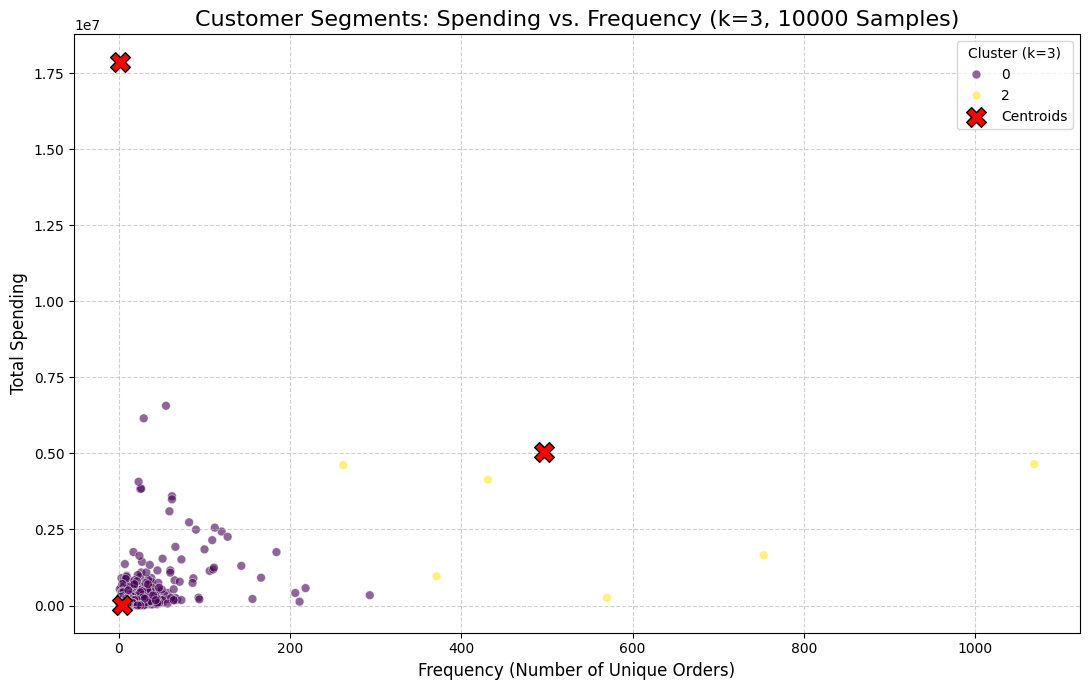

In [28]:
if 'cluster' not in customer_agg.columns:
    print("Error: Cluster labels not found. Skipping analysis.")
else:
    print("\n--- Analyzing Cluster Characteristics ---")
    cluster_analysis = customer_agg.groupby('cluster')[actual_features].mean()
    cluster_analysis['cluster_size'] = cluster_counts
    overall_mean = customer_agg[actual_features].mean()
    overall_mean['cluster_size'] = customer_agg.shape[0]
    cluster_analysis.loc['Overall Mean'] = overall_mean

    print("\nCluster Profile (Mean Values & Size):")
    display(cluster_analysis.style.format("{:,.2f}"))

    print("\n--- Visualizing Clusters ---")


    plt.figure(figsize=(11, 7))
    plot_sample_size = min(len(customer_agg), 10000)
    scatter_data = customer_agg.sample(plot_sample_size, random_state=42)

    sns.scatterplot(data=scatter_data, x='frequency', y='total_spending', hue='cluster',
                    palette='viridis', s=40, alpha=0.6, legend='full')

    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=actual_features)
    if 'frequency' in centroids_df.columns and 'total_spending' in centroids_df.columns:
        plt.scatter(centroids_df['frequency'], centroids_df['total_spending'], marker='X', s=200,
                    c='red', edgecolor='black', label='Centroids', zorder=5)

    plt.title(f'Customer Segments: Spending vs. Frequency (k={chosen_k}, {plot_sample_size} Samples)', fontsize=16)
    plt.xlabel('Frequency (Number of Unique Orders)', fontsize=12)
    plt.ylabel('Total Spending', fontsize=12)


    can_log_scale_x = (scatter_data['frequency'] > 0).all()
    can_log_scale_y = (scatter_data['total_spending'] > 0).all()
    if can_log_scale_x and can_log_scale_y:
         plt.xscale('log')
         plt.yscale('log')
         plt.xlabel('Frequency (Log Scale)', fontsize=12)
         plt.ylabel('Total Spending (Log Scale)', fontsize=12)
         plt.title(f'Customer Segments: Spending vs. Frequency (Log Scale, k={chosen_k}, {plot_sample_size} Samples)', fontsize=16)
    elif not can_log_scale_x:
         print("Note: Log scale for Frequency skipped due to non-positive values in sample.")
    elif not can_log_scale_y:
         print("Note: Log scale for Spending skipped due to non-positive values in sample.")

    plt.legend(title=f'Cluster (k={chosen_k})')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Cluster 2: Possible Spurious Data Point

## Why Cluster 2 Might Be Spurious:

- **Unusual Behavior**:
  - This behavior is rare and does not match the majority pattern in the dataset.

- **Possible Reasons**:
  - **Data Entry Errors**:
    - A single transaction could have been recorded with an incorrect or inflated amount.
  - **One-Off Bulk Purchases**:
    - Some customers may have made a very large one-time order, which is not representative of regular behavior.
  - **Fraudulent or Test Data**:
    - Sometimes internal system tests or fraudulent transactions can appear as huge spenders.


## Key Observations:

- **Cluster 0 (Bottom-left dense cluster)**:
  - Low frequency and low spending.
  - Majority of customers fall here.
  - Represents small or inactive buyers.

- **Cluster 1 (Sparse, far right cluster)**:
  - Very high frequency of orders.
  - Moderate spending levels compared to their order count.
  - Likely loyal customers making many small purchases.


# Feature Distributions and Cluster Interpretation

- Visualize each feature across clusters using boxplots:
  - Apply log scale to features if all values are positive.
  - Otherwise, filter extreme outliers using IQR (Interquartile Range).
- Helps understand how feature distributions vary between clusters.

- Summarize each cluster's profile:
  - Compare cluster averages to overall averages.
  - Classify clusters based on spending, frequency, and average order value (AOV).

- Final Output:
  - Each cluster is described with key traits and a suggested customer segment name.

---

# Feature Distributions by Cluster

- Create boxplots to visualize how each feature varies across different clusters.
- Apply log scaling if all feature values are positive (to handle wide range spreads).
- If log scale is not applicable, use IQR filtering to hide extreme outliers.
- Helps compare the behavior of different clusters on key features like spending, frequency, etc.
- Provides an intuitive view of cluster differences.


--- Visualizing Feature Distributions by Cluster ---


C:\Users\Salaar Masood\AppData\Local\Temp\ipykernel_23728\220999255.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_to_show, x='cluster', y=feature, ax=ax, palette='viridis', showfliers=False)
C:\Users\Salaar Masood\AppData\Local\Temp\ipykernel_23728\220999255.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data_to_show, x='cluster', y=feature, ax=ax, palette='viridis', showfliers=False)
C:\Users\Salaar Masood\AppData\Local\Temp\ipykernel_23728\220999255.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(

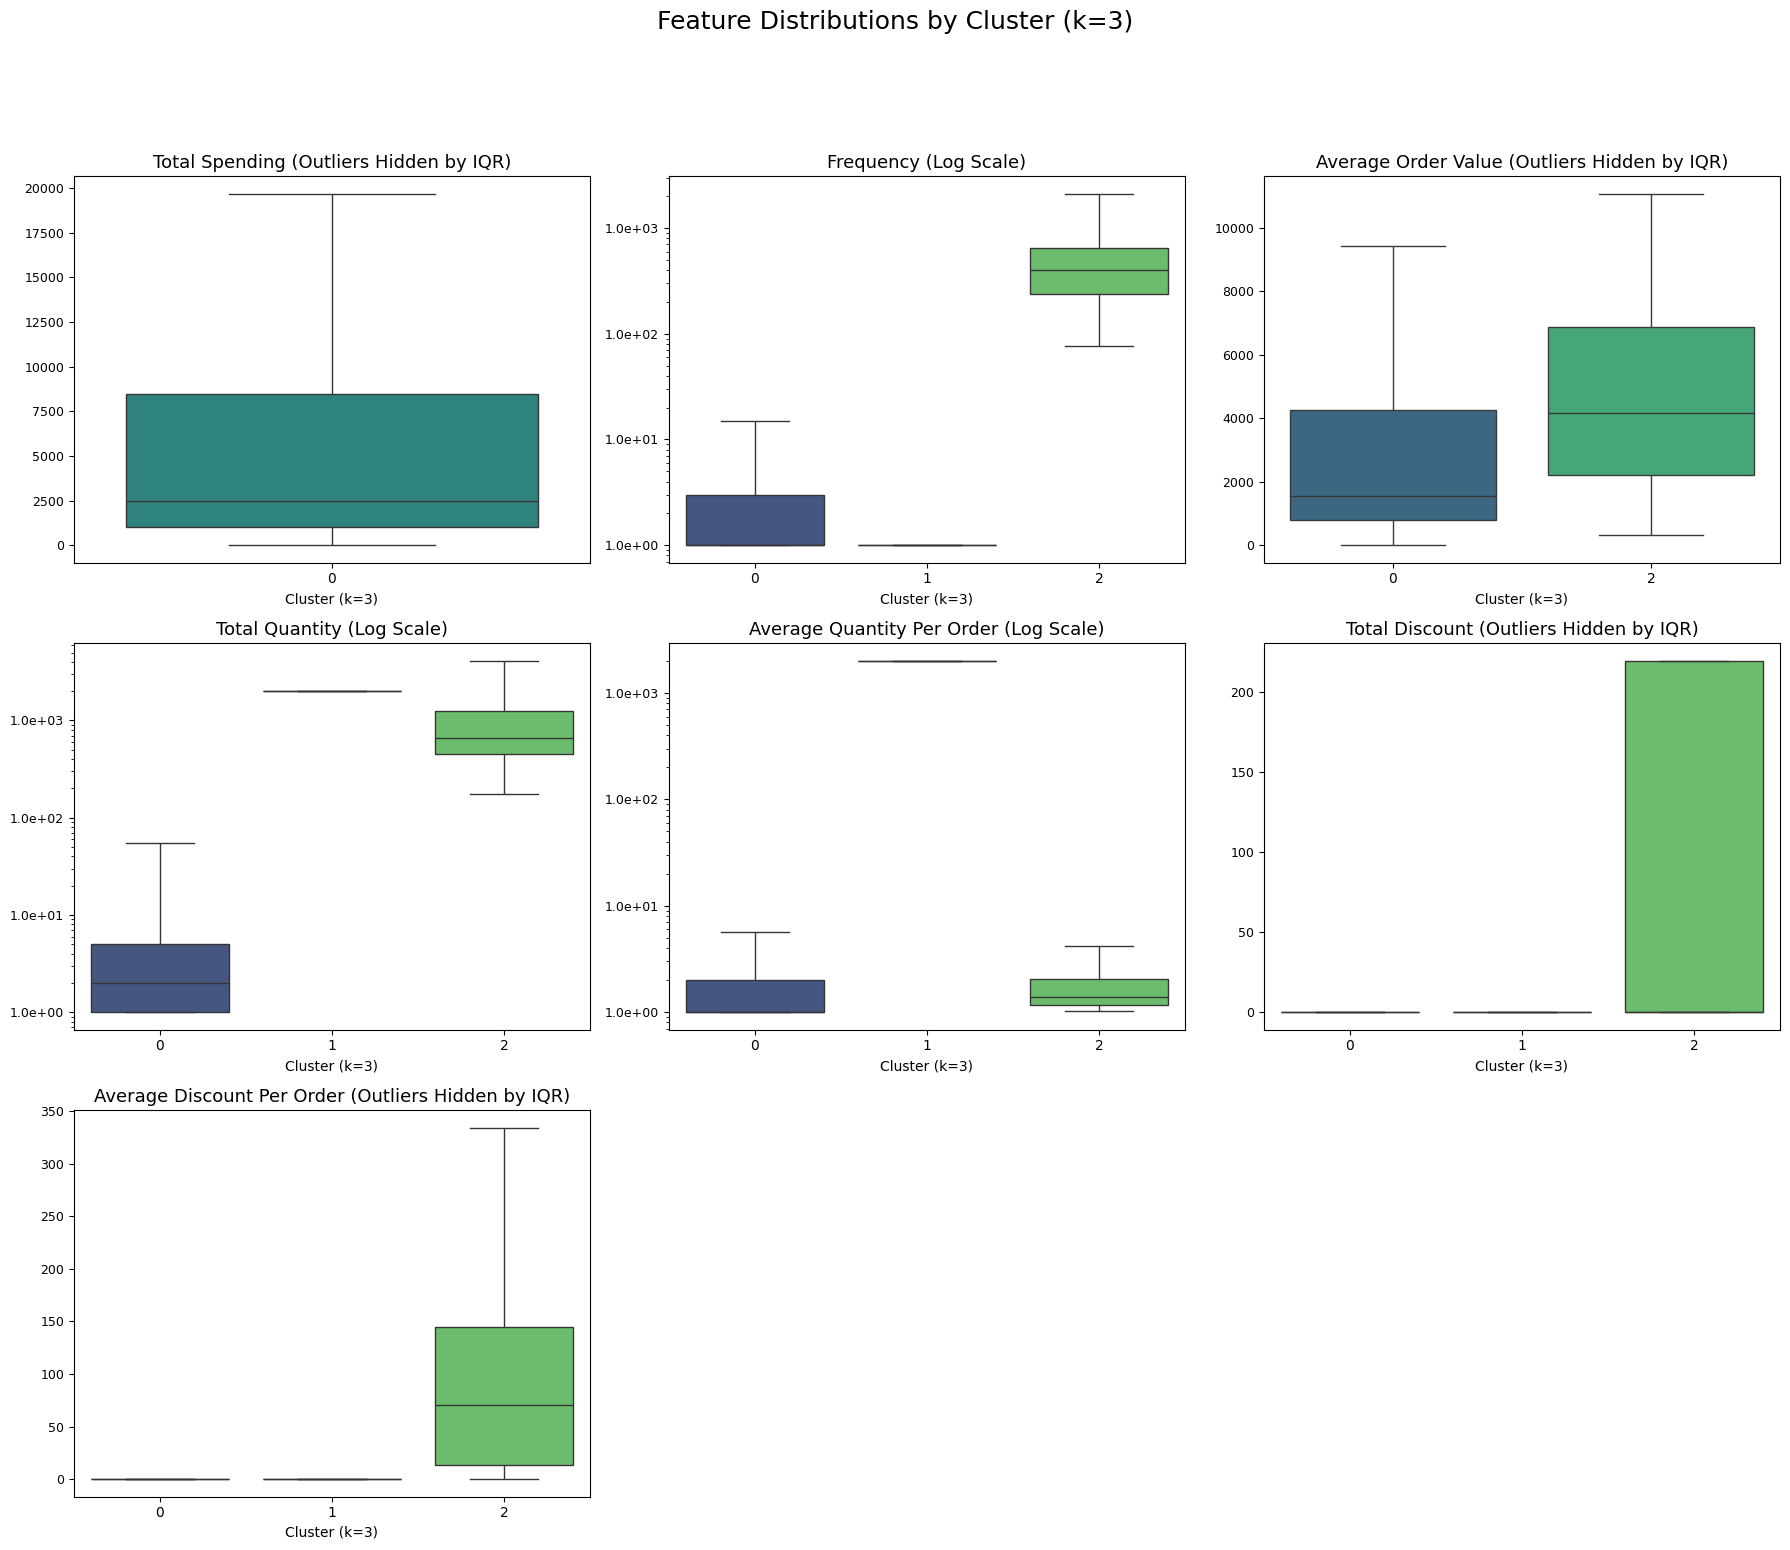


--- Cluster Interpretation Summary (k=3) ---

Cluster 0 (Size: 115004, 99.9% of total)
  Key Traits: Average Spending, Average Frequency, Average AOV
  Suggested Profile: Core Customers

Cluster 1 (Size: 1, 0.0% of total)
  Key Traits: Very High Spending, Very Infrequent, High AOV
  Suggested Profile: Big Spenders (Occasional)

Cluster 2 (Size: 76, 0.1% of total)
  Key Traits: Very High Spending, Very Frequent, High AOV
  Suggested Profile: VIP Loyalists

Note: Thresholds and segment names are heuristic suggestions based on averages.

--- Customer Segmentation Analysis Complete ---


In [35]:
print("\n--- Visualizing Feature Distributions by Cluster ---")
num_features_plot = len(actual_features)
ncols_plot = min(3, num_features_plot)
nrows_plot = int(np.ceil(num_features_plot / ncols_plot))
fig, axes = plt.subplots(nrows=nrows_plot, ncols=ncols_plot, figsize=(ncols_plot * 6, nrows_plot * 5), squeeze=False)
axes = axes.flatten()

for i, feature in enumerate(actual_features):
    ax = axes[i]
    plot_data = customer_agg[['cluster', feature]].copy()
    log_scale_applied = False
    title_suffix = ""

    if (plot_data[feature] > 0).all():
        try:
            ax.set_yscale('log')
            log_scale_applied = True
            title_suffix = " (Log Scale)"
            ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
        except Exception as e:
                print(f"Could not apply log scale to {feature}: {e}")
                log_scale_applied = False

    if not log_scale_applied:
        Q1 = plot_data[feature].quantile(0.25)
        Q3 = plot_data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        plot_data_filtered = plot_data[(plot_data[feature] >= lower_bound) & (plot_data[feature] <= upper_bound)]

        if len(plot_data_filtered) / len(plot_data) > 0.1:
                plot_data_to_show = plot_data_filtered
                title_suffix = " (Outliers Hidden by IQR)"
        else:
                plot_data_to_show = plot_data
                title_suffix = " (Outliers Present)"
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
    else:
            plot_data_to_show = plot_data

    sns.boxplot(data=plot_data_to_show, x='cluster', y=feature, ax=ax, palette='viridis', showfliers=False)

    ax.set_title(f'{feature.replace("_", " ").title()}{title_suffix}', fontsize=13)
    ax.set_xlabel(f'Cluster (k={chosen_k})', fontsize=10)
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=9)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Feature Distributions by Cluster (k={chosen_k})', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


print(f"\n--- Cluster Interpretation Summary (k={chosen_k}) ---")
analysis_sorted = cluster_analysis.drop('Overall Mean').sort_index()
overall_means = cluster_analysis.loc['Overall Mean']

thresholds = {'Very High': 1.75, 'High': 1.15, 'Low': 0.85, 'Very Low': 0.5}

for cluster_id in analysis_sorted.index:
    cluster_data = analysis_sorted.loc[cluster_id]
    size = cluster_data['cluster_size']
    percentage = size / overall_means['cluster_size'] * 100
    print(f"\nCluster {cluster_id} (Size: {int(size)}, {percentage:.1f}% of total)")

    desc = []
    relative_spend = cluster_data['total_spending'] / overall_means['total_spending'] if overall_means['total_spending'] else 1
    relative_freq = cluster_data['frequency'] / overall_means['frequency'] if overall_means['frequency'] else 1
    relative_aov = cluster_data['average_order_value'] / overall_means['average_order_value'] if overall_means['average_order_value'] else 1


    if relative_spend >= thresholds['Very High']: desc.append("Very High Spending")
    elif relative_spend >= thresholds['High']: desc.append("High Spending")
    elif relative_spend <= thresholds['Very Low']: desc.append("Very Low Spending")
    elif relative_spend <= thresholds['Low']: desc.append("Low Spending")
    else: desc.append("Average Spending")

    if relative_freq >= thresholds['Very High']: desc.append("Very Frequent")
    elif relative_freq >= thresholds['High']: desc.append("Frequent")
    elif relative_freq <= thresholds['Very Low']: desc.append("Very Infrequent")
    elif relative_freq <= thresholds['Low']: desc.append("Infrequent")
    else: desc.append("Average Frequency")

    if relative_aov >= thresholds['High']: desc.append("High AOV")
    elif relative_aov <= thresholds['Low']: desc.append("Low AOV")
    else: desc.append("Average AOV")

    print(f"  Key Traits: {', '.join(desc)}")


    segment_name = f"General Segment {cluster_id}"
    if "Very High Spending" in desc and "Very Frequent" in desc: segment_name = "VIP Loyalists"
    elif ("High Spending" in desc or "Very High Spending" in desc) and ("Frequent" in desc or "Very Frequent" in desc): segment_name = "High Value Regulars"
    elif ("Low Spending" in desc or "Very Low Spending" in desc) and ("Infrequent" in desc or "Very Infrequent" in desc): segment_name = "Low Engagement / At Risk"
    elif ("High Spending" in desc or "Very High Spending" in desc) and ("Infrequent" in desc or "Very Infrequent" in desc): segment_name = "Big Spenders (Occasional)"
    elif ("Average Spending" in desc or "Low Spending" in desc) and ("Frequent" in desc or "Very Frequent" in desc): segment_name = "Frequent Browsers / Small Buys"
    elif "Average Spending" in desc and "Average Frequency" in desc and "Average AOV" in desc: segment_name = "Core Customers"


    print(f"  Suggested Profile: {segment_name}")
print("\nNote: Thresholds and segment names are heuristic suggestions based on averages.")

print("\n--- Customer Segmentation Analysis Complete ---")

## RQ3: Can we predict future sales by looking at historical data? ##

## 1. Load & Filter the Dataset
- The dataset `preprocessed_dataset.csv` is loaded, with `created_at` parsed as a datetime column.
- Only rows where the `status` is `'complete'` or `'canceled'` are kept.
- The `grand_total` column is converted to numeric, coercing errors (e.g., invalid entries become `NaN`).
- Rows with missing `created_at` or `grand_total` values are dropped.
- `created_at` is ensured to be in datetime format.

## 2. Aggregate Monthly Sales
- The data is resampled at a monthly frequency (`'ME'` = month-end).
- For each month, the total `grand_total` (i.e., sales revenue) is summed up.
- The result is a new time series (`monthly`) representing total sales per month.

This prepares the dataset for time series analysis and forecasting.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# load the dataset
df = pd.read_csv(
    'preprocessed_dataset.csv',
    parse_dates=['created_at'], low_memory=False
)
df = df[df['status'].isin(['complete','canceled'])]
df['grand_total'] = pd.to_numeric(df['grand_total'], errors='coerce')
df = df.dropna(subset=['created_at','grand_total'])
df['created_at'] = pd.to_datetime(df['created_at'])

monthly = (
    df.set_index('created_at')['grand_total']
      .resample('ME')  # month-end
      .sum()
)


# Explanation of the Code

## 3. Train/Test Split (80% Train, 20% Test)
- **Purpose**: To evaluate the model's performance fairly, we split the time series into a **training set** (for model building) and a **test set** (for validation).
- **How**:
  - `n_train` calculates 80% of the total data length.
  - `train` contains the first 80% of the data.
  - `test` contains the remaining 20%.
- **Reason**: In time series, it's important to **preserve chronological order** (no shuffling), so we simply split based on time.


  - **Message**: "Not enough data for seasonality; using trend only."

## Why This Approach?
- **Model Flexibility**: We adapt the complexity of the model depending on how much data we have.
- **Avoid Overfitting**: If we don't have enough seasonal cycles, forcing a seasonal model would lead to poor generalization.
- **Time Series Best Practice**: Holt-Winters is ideal for data with trend and/or seasonality patterns.

---

In [31]:

# train-test split
n_train = int(len(monthly) * 0.8)
train = monthly.iloc[:n_train]
test  = monthly.iloc[n_train:]

# selecting seasonal period: quarterly = 4 months
# require at least two cycles (8 months) to include seasonality
if len(train) >= 8:
    hw_model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=4
    ).fit()
    print("Using quarterly seasonality (period=4).")
else:
    hw_model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal=None
    ).fit()
    print("Not enough data for seasonality; using trend only.")


Using quarterly seasonality (period=4).


c:\Users\Salaar Masood\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Model
- **Holt-Winters Exponential Smoothing** with additive trend and optional additive seasonality (quarterly, if enough data).

## 5. Forecast
- Predict future values for the test period.

## 6. Evaluate
- Compare predictions to actuals.
- Metrics calculated: MSE, RMSE, MAE, R².

In [32]:
# forecast
forecast = hw_model.forecast(len(test))

# evaluate where actuals exist
valid = ~test.isna()
y_true = test[valid]
y_pred = forecast[valid]

metrics = {
    'MSE':  mean_squared_error(y_true, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE':  mean_absolute_error(y_true, y_pred),
    'R2':   r2_score(y_true, y_pred)
}

## 7. Plot Actual vs Forecast
- Plot:
  - Training actual values.
  - Testing actual values.
  - Forecasted values (dashed line).
- Add title, labels, legend, and grid for better visualization.
- Purpose: Visually compare how well the forecast follows actual sales over time.


Forecast metrics: {'MSE': 1.3286978900110666e+16, 'RMSE': 115269158.4948492, 'MAE': 86415730.10349102, 'R2': -0.035474910938163795}


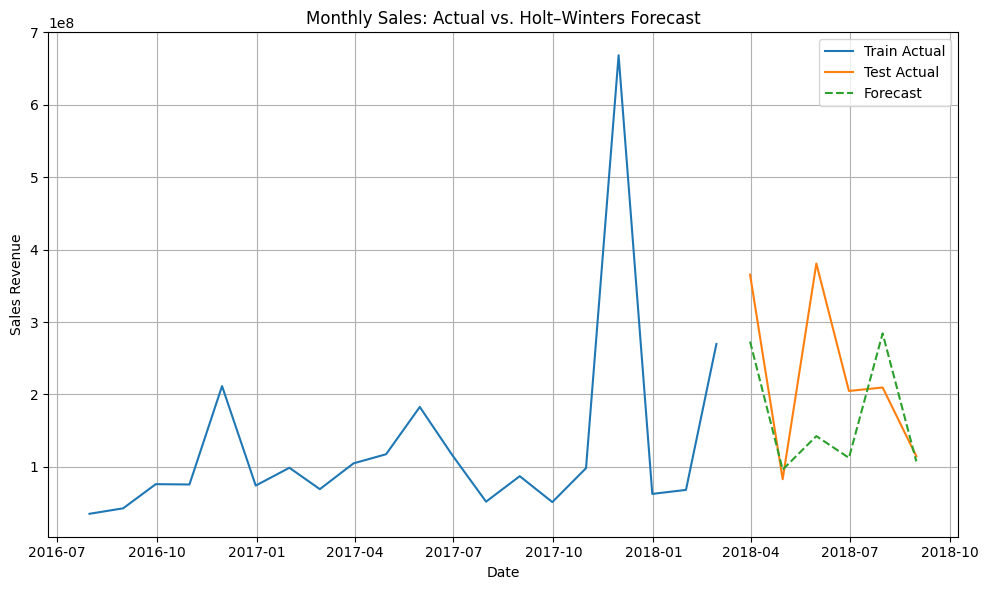

In [33]:
print("\nForecast metrics:", metrics)

plt.figure(figsize=(10,6))
plt.plot(train.index, train.values, label='Train Actual')
plt.plot(test.index,  test.values,  label='Test Actual')
plt.plot(forecast.index, forecast.values, '--', label='Forecast')
plt.title('Monthly Sales: Actual vs. Holt–Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Interpretation and Analysis of Forecast Plot

## 1. Plot Overview
- The plot shows:
  - **Train Actual** (blue line): Actual sales data used for model training.
  - **Test Actual** (orange line): Actual sales data used for testing (future unseen data).
  - **Forecast** (green dashed line): Sales predicted by the Holt-Winters model.

## 2. Key Observations
- The **training data** has noticeable fluctuations and a large sales spike around late 2017.
- The **test data** also shows sharp up-and-down movements, indicating high variability in sales.
- The **forecasted values** (green dashed) generally follow the overall trend but sometimes miss the sharp spikes or dips.
  - The model captures the overall **seasonal pattern** and **trend direction**, but struggles with the **extreme fluctuations**.

## 3. Model Behavior
- The Holt-Winters model is good at predicting **general levels** and **seasonal patterns**, but:
  - It **lags** during rapid changes.
  - It **underpredicts** sudden large spikes.
- This is expected because **Exponential Smoothing** models are better suited for smoother series and can struggle with **high volatility**.

## 4. Conclusion
- The model provides a **reasonable approximation** of sales behavior over time.
- However, for **highly volatile** data, more advanced models (e.g., ARIMA, Prophet, or machine learning approaches) could potentially offer better performance.

---